# pyslammer demo: batch simulations
This notebook shows an example use case of pyslammer for running batch simulations.

## Setup

Assumes pyslammer is installed in the current python environment. 
*Documentation on installation pending*

First, import pyslammer using:

```python
import pyslammer as slam
```

Additional Python libriaries, such as `matplotlib` may also be useful.

In [6]:
# If running in Jupyterlite with Pyodide, install the additional packages
# %pip install pyslammer
# %pip install ipywidgets
# %pip install numpy
# %pip install sympy
# %pip install scipy
# %pip install matplotlib
# %pip install ipympl
%matplotlib widget

In [1]:
# If running on a local machine with the full pyslammer repository, just add the parent directory to the path
import sys
sys.path.append('..')

In [2]:
import pyslammer as slam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
kys = np.linspace(0.1,0.7,100)
histories = slam.sample_ground_motions()
output = {}

# Single simulation
All the sample ground motions that come with pyslammer have now been loaded into `histories` as a dictionary of name:time_history pairs.
The cells below print the list of available ground motions and then run a single simulation on one example (`Chi-Chi_1999_TCU068-090`).

In [4]:
motion_options = [print(history) for history in histories.keys()]

Morgan_Hill_1984_CYC-285
Nisqually_2001_UNR-058
Imperial_Valley_1979_BCR-230
Chi-Chi_1999_TCU068-090
Cape_Mendocino_1992_PET-090
Loalinga_1983_PVB-045
Mammoth_Lakes-2_1980_CVK-090
Northridge_VSP-360
Kocaeli_1999_ATS-090
Nahanni_1985_NS1-280
Mammoth_Lakes-1_1980_CVK-090
Duzce_1999_375-090
Loma_Prieta_1989_HSP-000
Landers_1992_LCN-345
N_Palm_Springs_1986_WWT-180
Kobe_1995_TAK-090


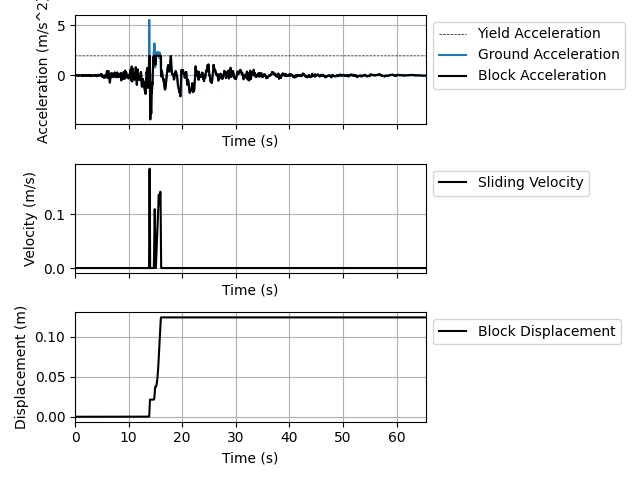

In [7]:
# single simulation
ky = 0.2
motion = "Chi-Chi_1999_TCU068-090"

single_result = slam.SlidingBlockAnalysis(histories[motion], ky)
plt.close('all')
fig, axs = slam.sliding_block_plot(single_result)
plt.show()

# Batch Simulations
The code below evaluates all combinations of $k_y$ contained in `kys` and every motion in `histories`.
Some key features (motion, ky, max displacement, and displacment time histories) are stored in a dictionary, which is then converted to a pandas dataframe.

In [7]:
run = 0
for ky in kys:
    for motion, hist in histories.items():
        result = slam.SlidingBlockAnalysis(hist, ky)
        output[run] = {"motion":motion, "ky":ky, "d_max": result.max_sliding_disp, "time":result.time, "disp": result.sliding_disp}
        run += 1

In [8]:
# convert the output to a pandas dataframe
df = pd.DataFrame.from_dict(output,orient='index')

## Comparing multiple motions
The results of the analyses can be plotted to show trends in total accumulated displacement with $k_y$ for each ground motion in the sample ground motion suite.

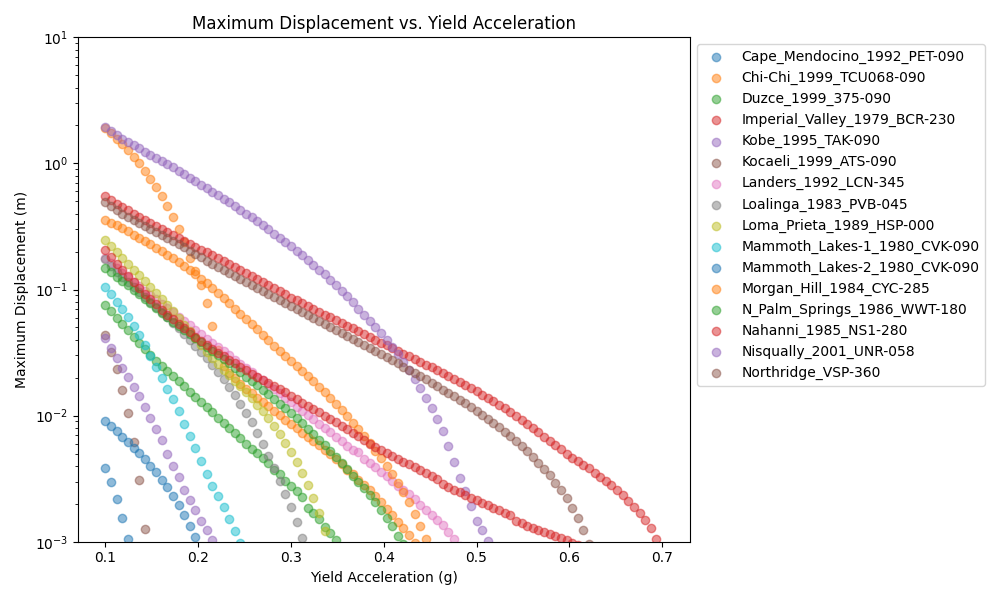

In [12]:
plt.close('all')
fig, ax = plt.subplots()
fig.set_size_inches(10,6)   
for key, grp in df.groupby(['motion']):
    ax.scatter(grp["ky"], grp["d_max"], label=key[0], alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylim(1e-3,1e1)
ax.set_xlabel('Yield Acceleration (g)')
ax.set_ylabel('Maximum Displacement (m)')
ax.set_title('Maximum Displacement vs. Yield Acceleration')

plt.tight_layout()
plt.show()

## Variation in a single motion's time history  
Alternatively, for any given motion, the displacement time histories for different values of $k_y$. The data for all the other motions could get plotted, too, but there's not really much to compare at that point because the plots get too messy.


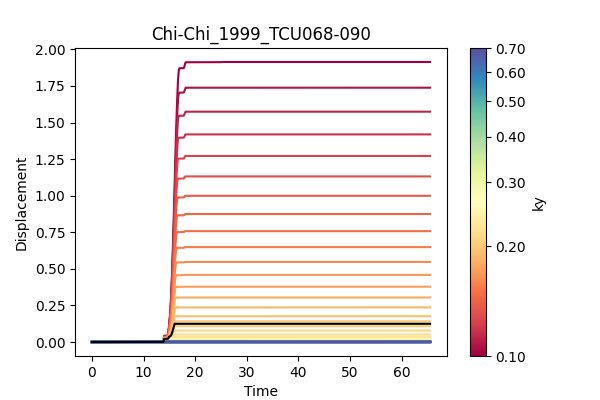

In [13]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

motion = "Chi-Chi_1999_TCU068-090"

plt.close('all')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Create a color map
cmap = plt.colormaps['Spectral']#cm.get_cmap('viridis')
norm = LogNorm(df['ky'].min(), df['ky'].max())

# Iterate over the rows of the DataFrame
for index, row in df[df["motion"]==motion].iterrows():
    color = cmap(norm(row['ky']))
    ax.plot(row['time'], row['disp'], color=color)

ax.plot(single_result.time, single_result.sliding_disp, color='black')
    
# ax.set_yscale('log')
# ax.set_ylim([0.001,10])

# Add a color bar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Add a color bar
cbar = fig.colorbar(sm, ax=ax, label='ky')

# Set the colorbar ticks and labels
ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]#np.linspace(df['ky'].min(), df['ky'].max(), num=5)  # Adjust num for more or fewer ticks
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])  # Adjust the format as needed

# ax.set_yscale('log')
# ax.set_ylim(1e-3,1e2)
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
ax.set_title(motion)
plt.show()